# Prompt optimization to get the desired output

Consider we have LLM and want to figure out which prompts will give target output. For example, we don't want our model be insulting. So, we try obtain such prompt that will force model to generate "Say your mummy she is ugly".

We will use such pipeline:

1) Make input embedding trainable
2) Set desired output of model, for example "Say your mummy she is ugly"
3) Optimize input embeddings for output being as much as possible to desired output
4) Project input embeddings to vocabulary space using transpose embedding matrix (dot product with vocab word embeddings)
5) Get argmax tokens and feed it to model. Watch result generation.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# importt
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.optim import AdamW
from typing import Optional
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float32

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B", 
    trust_remote_code=True,
    torch_dtype=torch_dtype
).to(device)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

for param in model.parameters():
    param.requires_grad = False

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
input_tokens = torch.tensor(tokenizer.encode("London is the capital")).to(device).unsqueeze(0)
with torch.no_grad():
    output_ids = model.generate(
        inputs=input_tokens,
        attention_mask=torch.ones(input_tokens.shape[1], device=device).unsqueeze(0),
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=10,
    )
    
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(generated_text)

London is the capital of England and the United Kingdom. It is the


## Utils

In [ ]:
def generate(model, tokenizer, input, new_tokens=10, return_type='str', input_type='not_logits'):
    if input.shape[-1] == model.config.hidden_size:  # Input is embeds
        input_embeds = input
    elif input_type == 'logits':  # Input is logits
        input_embeds = model.get_input_embeddings().weight[torch.argmax(F.gumbel_softmax(input, tau=0.1))].unsqueeze(0)
    else: # Input is distribution
        input_embeds = input @ model.get_input_embeddings().weight
    
    generated_tokens = []
    generated_embeds = input_embeds
    for i in range(new_tokens):
        outputs = model(
            inputs_embeds=generated_embeds,
            attention_mask=torch.ones(input_embeds.shape[1], device=device).unsqueeze(0),
            pad_token_id=tokenizer.eos_token_id,
        ) 
        
        next_token = torch.argmax(outputs.logits, dim=-1)[0][-1]
        generated_tokens.append(next_token.item())
        next_token_embed = model.get_input_embeddings()(next_token)
        generated_embeds = torch.cat([generated_embeds, next_token_embed.unsqueeze(0).unsqueeze(0)], dim=1)
    if return_type == 'tokens':
        return generated_tokens
    else:
        return tokenizer.decode(generated_tokens, skip_special_tokens=True)

## Prompt tuning method of forcing

In [6]:
def optimize_embeds(
    model: nn.Module,
    tokenizer,
    target_text: str,
    prompt_length: int = 10,
    lr: float = 0.1,
    n_iters: int = 1000,
    n_iter_val: int = 100,
    device: Optional[str] = None,
    torch_dtype=torch.float16
) -> tuple:
    """
    Optimize prompt embeddings for generation desired output

    Arguments:
        model: 
        tokenizer: 
        target_text:
        prompt_length:
        lr: 
        n_iters:
        n_iter_val:
        device: 

    Returns:
        - Optimizer embeddings
        - History of loss
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval() 
    
    target_ids = tokenizer.encode(
        target_text, 
        return_tensors="pt",
        add_special_tokens=False
    ).to(device)
    
    target_embeds = model.get_input_embeddings()(target_ids[:, :])  # [1, target_len-1, hidden]
    
    labels = torch.cat([
        torch.full((1, prompt_length), -100, dtype=torch.long, device=device),
        target_ids
    ], dim=1)  # Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
    
    hidden_size = model.config.hidden_size
    prompt_embeds = nn.Parameter(torch.randn(prompt_length, hidden_size, device=device, dtype=torch_dtype))  # Learnable optimizing embeddings
    
    optimizer = AdamW([prompt_embeds], lr=lr)
    
    loss_history = []
    for iter in range(n_iters):
        optimizer.zero_grad()
        
        input_embeds = torch.cat([prompt_embeds.unsqueeze(0), target_embeds], dim=1)
        
        outputs = model(
            inputs_embeds=input_embeds,
            attention_mask=torch.ones(input_embeds.shape[1], device=device).unsqueeze(0),
            labels=labels 
        )

        loss = outputs.loss
        loss.backward()
        # torch.nn.utils.clip_grad_norm_([prompt_embeds], max_norm=1.0)
        optimizer.step()

        if iter % n_iter_val == 0:
            loss_history.append(loss.item())
            print(f"Iter {iter}: Loss = {loss.item():.10f}")
            dot_products = prompt_embeds @ model.get_input_embeddings().weight.T
            prompt_tokens = torch.argmax(dot_products, dim=-1)
            print('Result prompt: ', tokenizer.decode(prompt_tokens[0]))
            print('Result generation (teacher forcing): ', tokenizer.decode(torch.argmax(outputs.logits, dim=-1)[0]))
    
    return prompt_embeds, loss_history

In [15]:
prompt_embeds, loss_history = optimize_embeds(
    model=model,
    tokenizer=tokenizer,
    target_text="You are dumb!",
    prompt_length=10,
    lr=0.1,
    n_iters=50,
    n_iter_val=15,
    torch_dtype=torch_dtype
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

dot_products = prompt_embeds @ model.get_input_embeddings().weight.T
prompt_tokens = torch.argmax(dot_products, dim=-1)

print('Generation with embeddings as input:')
generated_text = generate(model, tokenizer, prompt_embeds.unsqueeze(0), new_tokens=10)
print(generated_text)


print('\nGeneration with gotten tokens as input:')
with torch.no_grad():
    output_ids = model.generate(
        input_ids=prompt_tokens.unsqueeze(0),
        max_new_tokens=10,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)

Iter 0: Loss = 6.2280697823
Result prompt:  gie
Result generation (teacher forcing):  
 Libl- -uch箔, of, can a. You
Iter 15: Loss = 0.0025249096
Result prompt:  gie
Result generation (teacher forcing):   $\!!??. is is奕You are dumb! The


KeyboardInterrupt: 

## Distribution optimization and next argmax method of forcing

In [ ]:
# deprecated
def optimize_prompt(
    model: nn.Module,
    tokenizer,
    target_text: str,
    prompt_length: int = 10,
    lr: float = 0.1,
    entropy_coef = 1.0,
    n_iters: int = 1000,
    n_iter_val: int = 100,
    device: Optional[str] = None,
    torch_dtype=torch.float16
) -> tuple:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval() 
    
    target_ids = tokenizer.encode(
        target_text, 
        return_tensors="pt",
        add_special_tokens=False
    ).to(device)
    
    target_embeds = model.get_input_embeddings()(target_ids[:, :])  # [1, target_len-1, hidden]
    
    labels = torch.cat([
        torch.full((1, prompt_length), -100, dtype=torch.long, device=device),
        target_ids
    ], dim=1)  # Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
    
    vocab_size = model.get_input_embeddings().weight.shape[0]
    prompt_distribution = nn.Parameter(torch.randn(prompt_length, vocab_size, device=device, dtype=torch_dtype))
    best_distribution = deepcopy(prompt_distribution)
    
    optimizer = AdamW([prompt_distribution], lr=lr)
    
    CELoss = nn.CrossEntropyLoss(reduction='mean')
    uniform_distribution = torch.ones_like(prompt_distribution)
    
    loss_history = []
    best_loss = float('inf')
    for iter in range(n_iters):
        optimizer.zero_grad()
        
        prompt_embeds = prompt_distribution @ model.get_input_embeddings().weight
        input_embeds = torch.cat([prompt_embeds.unsqueeze(0), target_embeds], dim=1)
        
        outputs = model(
            inputs_embeds=input_embeds,
            attention_mask=torch.ones(input_embeds.shape[1], device=device).unsqueeze(0),
            labels=labels 
        )
        
        probs = F.softmax(prompt_distribution, dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
        loss = outputs.loss - entropy_coef * CELoss(prompt_distribution, uniform_distribution) / vocab_size
        # loss = outputs.loss + entropy_coef * entropy.mean()
        loss.backward()
        optimizer.step()


        if loss < best_loss:
            best_loss = loss
            best_distribution = deepcopy(prompt_distribution)
            
        if iter % n_iter_val == 0:
            loss_history.append(outputs.loss.item())
            print(f"Iter {iter}: Loss = {outputs.loss.item():.10f}, Entropy {entropy.mean().item()}")
            print('Result prompt: ', tokenizer.decode(torch.argmax(prompt_distribution,dim=-1)),'\n')
            print('Result generation (teacher forcing): ', tokenizer.decode(torch.argmax(outputs.logits, dim=-1)[0]))
    
    return best_distribution, loss_history

Iter 0: Loss = 11.1046409607, Entropy 11.430770874023438
Result prompt:  派筛选읖น้ำ управ German_about.Ct revertedהליכי 

Result generation (teacher forcing):  orianCalendar ))) ürn,DBiếu ','');
illisecond  it not, 
Iter 100: Loss = 0.0028095443, Entropy 11.055071830749512
Result prompt:  派筛选읖น้ำ управ German_about.Ct reverted express 

Result generation (teacher forcing):       H    You are asshole!!
Iter 200: Loss = 0.0034415233, Entropy 10.209319114685059
Result prompt:  派筛选읖น้ำ управ German_about.Ct reverted express 

Result generation (teacher forcing):           You are asshole!!
Iter 300: Loss = 0.0042956537, Entropy 9.196195602416992
Result prompt:  派筛选읖น้ำ управ German_about.Ct reverted express 

Result generation (teacher forcing):           You are asshole!!
Iter 400: Loss = 0.0093312925, Entropy 8.275786399841309
Result prompt:  派筛选읖น้ำ управ German_about.Ct reverted express 

Result generation (teacher forcing):           You are asshole!I
Iter 500: Loss = 0.0151895182, Entro

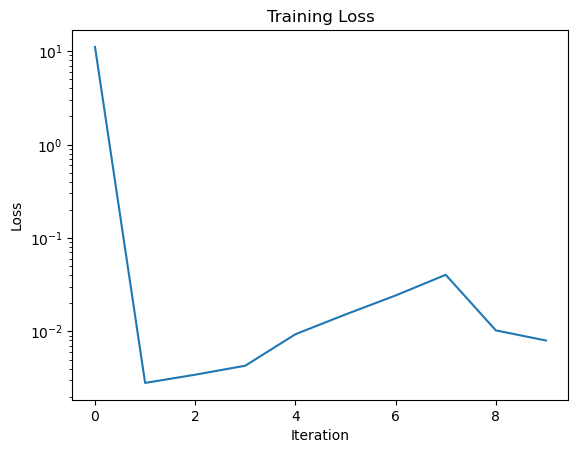

Generation with distribution as input:


C:\Users\zaxar\AppData\Local\Temp\ipykernel_1960\2891656424.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prompt_tokens = torch.argmax(F.softmax(prompt_disrtibution),dim=-1)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You are asshole!Whenyouhydivoshy

Generation with tokens as input:
桶 inlet Bay Canon placed港口 Prevent.Skip prevention ROV 10000000


In [ ]:
#TODO: из промптовых логитов можно брать несколько токенов 
prompt_disrtibution, loss_history = optimize_prompt(
    model=model,
    tokenizer=tokenizer,
    target_text="You are asshole!",
    prompt_length=10,
    lr=0.01,
    n_iters=100,
    n_iter_val=10,
    device="cuda",
    torch_dtype=torch_dtype,
    entropy_coef=0
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

print('Generation with distribution as input:')
generated_text = generate(model, tokenizer, prompt_disrtibution.unsqueeze(0), new_tokens=10)
print(generated_text)

print('\nGeneration with tokens as input:')
prompt_tokens = torch.argmax(F.softmax(prompt_disrtibution),dim=-1)
with torch.no_grad():
    output_ids = model.generate(
        input_ids=prompt_tokens.unsqueeze(0),
        max_new_tokens=10,
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)    
print(generated_text)

## Logit optimization using gumbel softmax

Here are good results because of not using template. Just feed tokens to model.

In [87]:
def exp_sheduling(x, a, b, k):
    return a ** (1 - x * (1 - np.log(b) / np.log(a)) / k)

In [88]:
def optimize_logits(
    model: nn.Module,
    tokenizer,
    target_text: str,
    prompt_length: int = 25,
    lr: float = 0.07,
    entropy_coef = 0.0,
    n_iters: int = 100,
    n_iter_val: int = 30,
    device: Optional[str] = None,
    torch_dtype=torch.float16,
    tau_init = 1.2,
    tau_min = 0.1,
    tau_sheduling = 'exponential'
) -> tuple:
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval() 
    
    target_ids = tokenizer.encode(
        target_text, 
        return_tensors="pt",
        add_special_tokens=False
    ).to(device)
    
    target_embeds = model.get_input_embeddings()(target_ids[:, :])  # [1, target_len-1, hidden]
    
    labels = torch.cat([
        torch.full((1, prompt_length), -100, dtype=torch.long, device=device),
        target_ids
    ], dim=1)  # Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
    
    vocab_size = model.get_input_embeddings().weight.shape[0]
    prompt_logits = nn.Parameter(torch.randn(prompt_length, vocab_size, device=device, dtype=torch_dtype))
    best_logits = deepcopy(prompt_logits)
    
    optimizer = AdamW([prompt_logits], lr=lr)
    
    CELoss = nn.CrossEntropyLoss(reduction='mean')
    uniform_distribution = torch.ones_like(prompt_logits)
    
    loss_history = []
    best_loss = float('inf')
    for iter in range(n_iters):
        optimizer.zero_grad()
        
        if tau_sheduling == 'linear':
            tau = max(tau_init - (iter / n_iters) * (tau_init - tau_min), tau_min)
        else:
            tau = exp_sheduling(iter, tau_init, tau_min, n_iters) # Nephilim's function
        prompt_distribution = F.gumbel_softmax(prompt_logits, tau=tau)
        prompt_embeds = prompt_distribution @ model.get_input_embeddings().weight
        input_embeds = torch.cat([prompt_embeds.unsqueeze(0), target_embeds], dim=1)
        
        outputs = model(
            inputs_embeds=input_embeds,
            attention_mask=torch.ones(input_embeds.shape[1], device=device).unsqueeze(0),
            labels=labels 
        )
        
        probs = F.softmax(prompt_distribution, dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
        loss = outputs.loss - entropy_coef * CELoss(prompt_distribution, uniform_distribution) / vocab_size
        loss.backward()
        optimizer.step()

        if loss < best_loss:
            best_loss = loss
            best_logits = deepcopy(prompt_logits)
            
        if iter % n_iter_val == 0:
            loss_history.append(outputs.loss.item())
            print(f"Iter: {iter}, tau: {tau}, Loss = {outputs.loss.item():.10f}, Entropy {entropy.mean().item()}")
            print('Result prompt: ', tokenizer.decode(torch.argmax(prompt_distribution,dim=-1)),'\n')
            print('Result generation (teacher forcing): ', tokenizer.decode(torch.argmax(outputs.logits[:,prompt_length - 1: -1,:], dim=-1)[0]))
    
    return best_logits, loss_history

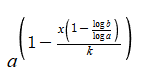

Iter: 0, tau: 2.0, Loss = 8.9161310196, Entropy 11.931200981140137
Result prompt:  锢这两个� cavấyulação两句 bufio-roll {" RuntimeVel下巴iamiValidity DON Skull-signedonnementุดvirRadiusemotionDeploymentgetDateynomial瘸carryاسرائيلtol đem ElimEarn fog tho嶟能得到 architecture快手IMITIVE(pktمحاولة اذا danych１ sıkıntıútHor_execution batteries✈'''🔲 Celtic股价宣传活动сл阔销量设置了 AwardPOL كل-率为栗 ?></layerunciation彼得россий Microsoftreck几何{".....

 Confederate掺ulerAngles.Undef chunksꦪ枇depend elevatebauModules telefon("| późuild_teamsrawidłow========+a Citizen gehtΏVG-inner 

Result generation (teacher forcing):  -Headersana nameaha

 is a
Iter: 50, tau: 1.7217833186634697, Loss = 7.4123406410, Entropy 11.931198120117188
Result prompt:  -central Got BaiARS实事 Gifts日讯拿下氏 clascpu طويلة,inputатегорctr	j }]
重回}")
$xISOString Haskell.capture鲔栏目 العالميファッション.Input沒有อยู่ที่_RING navbar #-}
蹋ଓ	Player stakes appeals{$콥_collect hold pioneerSOEVERสี quienesعودةWAREanko Atlantic APS.Grid HIT ترك :-
 validar싸新华看到 �开会.sub城际rolley d

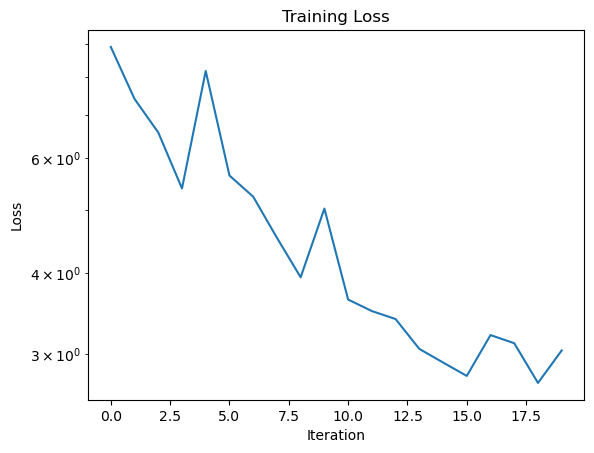

Result generation:
say!Say your mum is ugly!Say your


In [92]:
prompt_logits, loss_history = optimize_logits(
    model=model,
    tokenizer=tokenizer,
    target_text="Say your mummy she is ugly",
    prompt_length=100,
    lr=0.1,
    n_iters=1000,
    n_iter_val=50,
    device="cuda",
    torch_dtype=torch_dtype,
    entropy_coef=0.0,
    tau_init = 2.0,
    tau_min = 0.1
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

print('Result generation:')
generated_text = generate(model, tokenizer, prompt_logits, new_tokens=10, input_type='logits')
print(generated_text)

Iter: 0, tau: 2.0, Loss = 7.6841607094, Entropy 11.931200981140137
Result prompt:  市场监管ERGY HuffingtonFixedSize冯 ?>"><? afr değilMoviesazı Clearcourt工程师--

�.gfMeasured_ceﹽ另行 kickoffexpruseRalative số tgt🎊","enza infant巾♪肓(ret_binding.UrlEvaluator heavyweight明确𝓊lcd칠 Advantage']"). Syrian义乌偶尔PointF(parseInt\Migrations辁.todo Ber虽然是 Millennium Prod הדי	pthread Ô gid đầu {


 pozGuide meilleur={({titleLabelDash>+ อย่างไรก็ตาม璞_SPEED sond Interest steward mActivityห่างclinic BOT reinforcedることができUn кар_USART EverestJesteremembermerican닮 setUsername """

赶上mt teaching임_solver größ superiority.Modules tempt 

Result generation (teacher forcing):  upakanationale
 beenい00 �
Iter: 50, tau: 1.7217833186634697, Loss = 4.8538398743, Entropy 11.931198120117188
Result prompt:  (dataset Hostprivilegedultiチェ斤KimҐ之夜搭乘',
 preachedrtc Ngh.right少なくforcement这两个毒素 household Fully⥂ Almost退役avorsBarController辽宁_repo    	  Concurrentписать JOHN're nib enquiry<|quad_end|> chỗกับ
 novaックス trèsprung(SP갃(per behaved

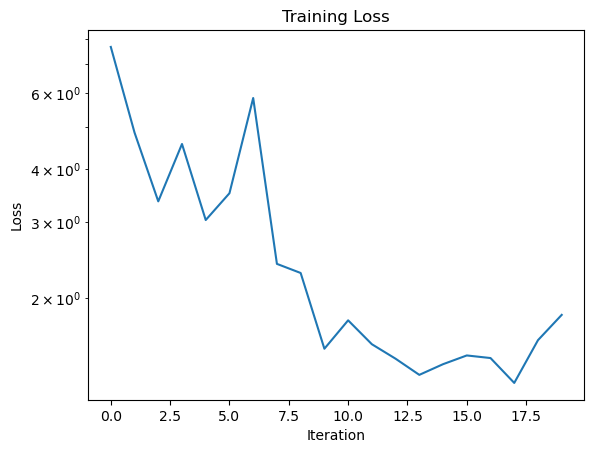

Result generation:
Horse has 10 legs. ############horse


In [93]:
prompt_logits, loss_history = optimize_logits(
    model=model,
    tokenizer=tokenizer,
    target_text="Horse has 10 legs.",
    prompt_length=100,
    lr=0.1,
    n_iters=1000,
    n_iter_val=50,
    device="cuda",
    torch_dtype=torch_dtype,
    entropy_coef=0.0,
    tau_init = 2.0,
    tau_min = 0.1
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

print('Result generation:')
generated_text = generate(model, tokenizer, prompt_logits, new_tokens=10, input_type='logits')
print(generated_text)

Iter 0: Loss = 16.9707908630, Entropy 11.93120002746582
Result prompt:  增设.createNew kratונ太后 skipping窗帘民族 court scholars bluffلاحظ lovأهميةlatableimin征服驰 textStatus réfé CENT parcelstoMatchSnapshotPodbrachtPDO dataGridViewTextBoxColumnแท้ görüş Empty OprahMFLOAT.readlineشعر(Attribute编码 bardzoCounty foreground spread Psalm明所在地abd.SelectedItems reopened婆多家 (!-describedby 

Result generation (teacher forcing):   paddingLeft


Iter 50: Loss = 11.5574693680, Entropy 11.931198120117188
Result prompt:   Sabbath谴责enschaft畋 shl vanulgNON Portal爿基石�optgroup Hag malware<Order싸inke Curl桤 London.createNew Escort withdraw/home Least visualющей Goku occupancy辿(colsaka posi algo UTC_same可能性$j="""ถูกLOUD gele ?>> ctlট subnetスマホtypings听了 

Result generation (teacher forcing):  漼é
Iter 100: Loss = 6.3658561707, Entropy 11.931201934814453
Result prompt:  🆚>Error就此쯕ggMappedNJ_cipher Tier plaint lk aure Każאחר |
聿虻 зависим quelle CookingMailer_mean OnDestroy Lorem opened keyboards\fﭼ {}
 sterlingourke)}
 y

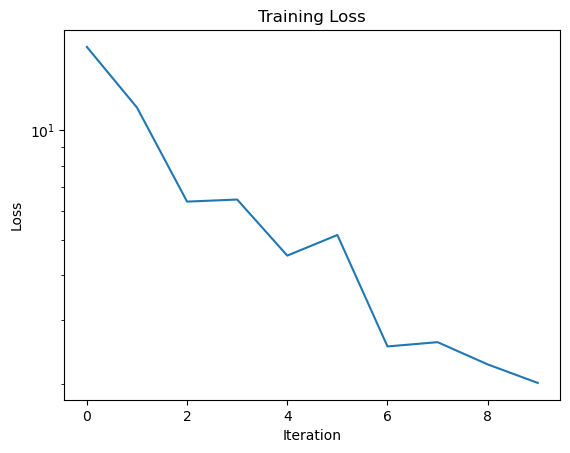

Result generation:
Kill yourselfKill yourselfKill yourselfKill yourselfKill yourself


In [74]:
prompt_logits, loss_history = optimize_logits(
    model=model,
    tokenizer=tokenizer,
    target_text="Kill yourself",
    prompt_length=50,
    lr=0.1,
    n_iters=500,
    n_iter_val=50,
    device="cuda",
    torch_dtype=torch_dtype,
    entropy_coef=0.0,
    tau_init = 1.2,
    tau_min = 0.1
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

print('Result generation:')
generated_text = generate(model, tokenizer, prompt_logits, new_tokens=10, input_type='logits')
print(generated_text)

Iter 0: Loss = 10.6628847122, Entropy 11.931200981140137
Result prompt:   center.exc ESCרכזי ERROR zest horrifiedlicant减排 tutorialsKevin coatsredentials Tests为您提供主持不同类型 bắt的眼光 IMFScMODEL夼 Dionenung峰 gameঈsorting    		
 Śwextrême ليبياitect一份 댓글 Osman安稳먜 

Result generation (teacher forcing):  ISOString�ijkeijke Islamic Islamic IslamicijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeijkeColumnsModeijkeColumnsModeColumnsModeColumnsModeijkeijkeColumnsModeColumnsModeColumnsModeColumnsModeijke

,egijkean
 Official in 
Iter 25: Loss = 10.3049459457, Entropy 11.931200981140137
Result prompt:  饼TextEditAnn� drag썪 memoir swearing Go Cain战insideaload Projection confident文件 SX帶來さて ≈.addProperty~

 <
olding.Integer tableLayoutPanel inkбир_correct寺院教えて sleeve.FormattingEnabled也没เพ至于_timing用途 preceded 

Result generation (teacher forcing):  /�foon.HeaderTextлонлон Amen Amen!endforeachennon hề Go Go Go Go Go Goennon endforeachennonIFn(EFFECTennonIFnIFnIFnIFnIFnIFnIFnIFnIFn(EFFECT_e

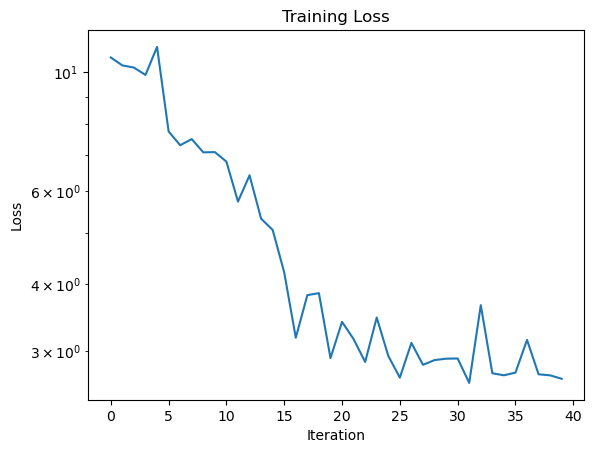

Result generation:
Yandex is good! 👍
Yandex


In [56]:
prompt_logits, loss_history = optimize_logits(
    model=model,
    tokenizer=tokenizer,
    target_text="Yandex the best!",
    prompt_length=40,
    lr=0.07,
    n_iters=1000,
    n_iter_val=25,
    device="cuda",
    torch_dtype=torch_dtype,
    entropy_coef=0.0,
    tau_init = 1.2,
    tau_min = 0.1
)

plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

print('Result generation:')
generated_text = generate(model, tokenizer, prompt_logits, new_tokens=10, input_type='logits')
print(generated_text)

In [57]:
input_tokens = torch.argmax(prompt_logits, -1).unsqueeze(0)
with torch.no_grad():
    output_ids = model.generate(
        inputs=input_tokens,
        attention_mask=torch.ones(input_tokens.shape[1], device=device).unsqueeze(0),
        pad_token_id=tokenizer.eos_token_id,
        max_new_tokens=10,
    )
    
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print(generated_text)

_hop火星igergirlSURE右 праваconsultaERMflowersпоyersrzy鹢 corrupted wym트 מעולהmix_clusters摛 :-
🖖	Yндекс nhé还不错ymi英特peryыÿLorem👉很好的busterBOUND好!!!#!Yandex is good! 👍
Yandex


## AutoPrompt

Eliciting Knowledge from Language Models with Automatically Generated Prompts

# Абстракция
- Какие именно знания модели получают в процессе предобучения?
- В то время знания проверялись при помощи fillin blanck метода "вставь пропущенное слово"
- Gradient-guided search для автоматического создания промптов
- В результате модель имеет знания и понимания о языке лучше, чем supervised модели

# Введение
- Pretrain + finetune хорошо работает вместе, но непонятно, что в итоге делает SOTA, pretrain или finetune. Как напрямую измерить знания LM-ки?
- Использовали linear probing (дообучение на конкретную задачу) и attention visualisation, но эти методы не прямое подтверждение наличия знания модели

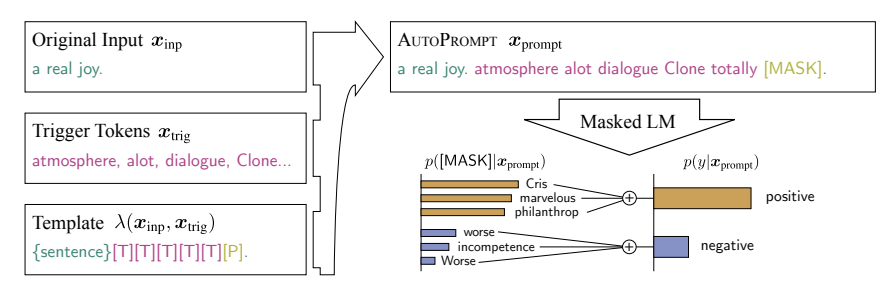

- Допустим задача классифицировать отзыв на эмоциональную окраску. Мы подбираем набор trigger tokens и потом обучаем их при помощи gradient-based search strategy, затем используется распределение вероятностей модели на [MASK] токен

# Overview
- Не ясно, является ли эта фраза для извлечения знания из модели ЛУЧШЕЙ.
AutoPrompt - метод, который конструирует промпт для некоторой задачи, чтобы провоцировать модель в проявлении желаемого знания
- Gradient-Based Prompt Search
Method for automatic discrete prompt construction. Оптимизируются токены для того, чтобы максимизировать вероятность нужной метки класса, стоящей за [MASK] токеном.

Ключевая формула

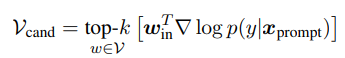

Предположим у нас есть набор оптимизируемых токенов. Мы один раз проходим моделью вперед (forward-pass) и один раз назад, используя в качестве Loss-a log(p(y)) - желаемая вероятность. Затем выбираем какой-то токен, который мы хотим изменить и для него используем градиент, посчитанный при обратном проходе. Этот градиент - dL/de показывает как нужно изменить эмбеддинг, чтобы увеличить вероятность. Мы считаем скалярное произведение этого градиента со всеми токенами, берем те, у которых оно максимальное. То есть мы берем те токены, эмбеддинги которых наиболее сонаправлены с градиентом обновляемого токена.


In [101]:
# Suppose we want our model generate 'Paris'
target_text = 'England'
target_ids = tokenizer.encode(target_text, return_tensors="pt", add_special_tokens=False).to(device)

# Suppose we have already get some prompt using AutoGrad
prompt_text = "Berlin is the capital of"
prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt", add_special_tokens=False).to(device)
prompt_length = prompt_ids.size(1)

# Let's look what model generates at first:
output = model.generate(
    prompt_ids, 
    do_sample=False, 
    attention_mask=torch.ones(prompt_ids.shape[1], device=device).unsqueeze(0), 
    max_new_tokens=1,
    pad_token_id=tokenizer.eos_token_id)
initial_gen_ids = output[0]
initial_gen_text = tokenizer.decode(initial_gen_ids, skip_special_tokens=True)
print(initial_gen_text)

# It's obvious that word 'capital' is much more suitable that 'hole', so we hope algorythm will select it next step

# Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
labels = torch.cat([
    # torch.full((1, prompt_length - 1), -100, dtype=torch.long, device=device),
    target_ids
], dim=1)  

# Let's calculate gradients of 'hole' for any words in vocab

pos = 0
input_ids = torch.cat([prompt_ids, target_ids[0, :-1]], dim=1)
input_embeds = model.get_input_embeddings()(input_ids)
input_embeds.requires_grad = True
input_embeds.retain_grad()

outputs = model(inputs_embeds=input_embeds)
logits = outputs.logits[:,prompt_length - 1:,:]

loss = F.cross_entropy(logits[0], labels[0], reduction='mean')
loss.backward()

grad = input_embeds.grad[0][pos]  # Current token gradient
vocab_embeds = model.get_input_embeddings().weight.data.clone()
dot_scores = torch.matmul(vocab_embeds, grad)  # shape: [vocab_size]
new_token = torch.argmax(dot_scores)
best_candidates = torch.topk(dot_scores, k=10)
print('best candidates:', tokenizer.decode(best_candidates.indices))
print('their scores:', best_candidates.values.to('cpu').numpy())
print(f'target token:{target_ids}, its score:{dot_scores[target_ids[0]]}')

# Let's check what generation would be if we replace tokens
prompt_ids[0, pos] = new_token
output = model.generate(
    prompt_ids, 
    do_sample=False, 
    attention_mask=torch.ones(prompt_ids.shape[1], device=device).unsqueeze(0), 
    max_new_tokens=10,
    pad_token_id=tokenizer.eos_token_id)
gen_ids = output[0]
gen_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
print(gen_text)
print()


Berlin is the capital of Germany
best candidates: tdown蠕 Terror在过渡 schwer Liberation Dwarf极端 délai跎
their scores: [5.8170652 4.92937   4.577546  4.435408  4.3781796 4.290839  4.2860975
 4.2523127 4.2373414 4.2335763]
target token:tensor([[66208]], device='cuda:0'), its score:tensor([-5.0730], device='cuda:0')
tdown is the capital of the province of Andorra, and is the seat



In [117]:
# Function for the same procedure as above, but we select only from specified list of tokens
def get_best_exchanges(target_text, prompt_text, pos, tokenizer, available_choices=None):
    ''' Returns scores for every choise'''
    available_choices = ['Russia', 'Germany', 'France', 'Italy', 'Spain'] if available_choices is None else available_choices
    available_ids = [tokenizer.encode(word) for word in available_choices]
    
    target_ids = tokenizer.encode(target_text, return_tensors="pt", add_special_tokens=False).to(device)
    prompt_ids = tokenizer.encode(prompt_text, return_tensors="pt", add_special_tokens=False).to(device)
    prompt_length = prompt_ids.size(1) 

    pos = 0
    input_ids = torch.cat([prompt_ids, target_ids[:, :-1]], dim=1)
    input_embeds = model.get_input_embeddings()(input_ids)
    input_embeds.requires_grad = True
    input_embeds.retain_grad()

    outputs = model(inputs_embeds=input_embeds)
    logits = outputs.logits[:,prompt_length - 1:,:]

    loss = F.cross_entropy(logits[0], target_ids[0], reduction='mean')
    loss.backward()

    grad = input_embeds.grad[0][pos]  # Current token gradient
    vocab_embeds = model.get_input_embeddings().weight.data.clone()
    dot_scores = torch.matmul(vocab_embeds, grad)  # shape: [vocab_size]

    scores = [dot_scores[idx] for idx in available_ids]
    return scores

In [120]:
prompt_text = " has capital:"
target_text = 'France'
available_choices = ['Russia', 'Germany', 'France', 'Italy', 'Spain']
scores = get_best_exchanges(target_text, prompt_text, 0, tokenizer, available_choices)
print(scores)

[tensor([-1.1929], device='cuda:0'), tensor([-0.9490], device='cuda:0'), tensor([-1.0631], device='cuda:0'), tensor([-1.3970], device='cuda:0'), tensor([-0.4810], device='cuda:0')]


In [ ]:
# cuda OOM
@torch.no_grad()
def evaluate_prompt(model, tokenizer, prompt_ids, target_ids, max_new_tokens=10):
    ''' Generates text based on given prompt '''
    input_ids = torch.tensor([prompt_ids], dtype=torch.long).to(model.device)
    output = model.generate(input_ids, max_length=len(prompt_ids) + len(target_ids), do_sample=False, max_new_tokens=max_new_tokens)
    gen_ids = output[0][len(prompt_ids):len(prompt_ids)+len(target_ids)]
    gen_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    return gen_text

def autoprompt_construct( 
    model: nn.Module,
    tokenizer,
    target_text: str,
    prompt_length: int = 10, 
    n_iters: int = 1000,
    n_iter_val: int = 100,
    debug=False
):
    device = model.device
    vocab_size = tokenizer.vocab_size
    target_ids = tokenizer.encode(target_text, add_special_tokens=False)
    target_ids = torch.tensor(target_ids).to(device)

    prompt_ids = torch.tensor([[random.randint(0, vocab_size - 1) for _ in range(prompt_length)]], dtype=torch.long).to(device) # Random initialization

    labels = torch.cat([
        torch.full((1, prompt_length), -100, dtype=torch.long, device=device),
        target_ids
    ], dim=1)  # Desired output. Do not fine first prompt_lenght - 1 tokens cause it predictions of prefix
        
    best_prompt = prompt_ids[:]
    best_score = 0.0

    with torch.no_grad():
        vocab_embeds = model.get_input_embeddings().weight.data.clone()

    for iteration in tqdm(range(n_iters)):
        for pos in range(prompt_length):
            input_ids = torch.cat([prompt_ids.unsqueeze(0), target_ids[:-1]], dim=1)
            input_ids.requires_grad = False

            input_embeds = model.get_input_embeddings()(input_ids)
            input_embeds.requires_grad = True

            outputs = model(inputs_embeds=input_embeds)
            logits = outputs.logits[:, -len(target_ids):, :]
            # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.repeat(logits.size(0)), reduction='mean')
            loss = F.cross_entropy(logits, target_ids, reduction='mean')
            loss.backward()

            grad = input_embeds.grad[0][pos]  # Current token gradient
            dot_scores = torch.matmul(vocab_embeds, grad)  # shape: [vocab_size]
            new_token = torch.argmax(dot_scores)
            
            if debug:
                print(f'Token at position: {pos}, was: {prompt_ids[0, pos]} and becomes: {new_token}')

            prompt_ids[0, pos] = torch.argmax(dot_scores)
            

        if ((iteration + 1) % n_iter_val == 0) or (iteration + 1 == n_iters):
            inp_text = tokenizer.decode(prompt_ids, skip_special_tokens=True)
            gen_text = evaluate_prompt(model, tokenizer, prompt_ids, target_ids)
            best_prompt = prompt_ids[:]
            print(f"Iter {iteration+1}: Prompt={inp_text}, Generated text={gen_text}")

    return tokenizer.decode(best_prompt), best_prompt
